# GLIMPSE CREATOR 

This notebook takes a cell_ID, or series of cell_IDs and crops a 'glimpse' of the cell; a series of images lasting the duration of the cells existence that are focused on the cell and it's immediate neighbourhood.

Author: `Nathan J. Day`

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, re
from scipy import ndimage
from skimage.io import imshow, imsave, imread #used to be from skimage import io
from sklearn import preprocessing
from matplotlib import animation
from natsort import natsorted
from pathlib import Path
from skimage.external import tifffile
from btrack.dataio import HDF5FileHandler
import glob
from tensorflow.python.keras.models import Model, load_model
import json
import zipfile
import scipy
from scipy.spatial import KDTree
from skimage.transform import resize
from multiprocessing import Pool
from skimage.external import tifffile
import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'sklearn'

### Tiff virtual stack functions

In [171]:
class VirtualTiffStack:
    def __init__(self, folder, channel_name):
        self.folder = folder 
        self.channel_name = channel_name
        # find the files and store them
        self.files = natsorted([file for file in os.listdir(os.path.join(self.folder, self.channel_name)) if file.endswith('.tif')])
        self.glimpse = [] ### would this work like this?????
    def __getitem__(self, idx):
        return tifffile.imread(os.path.join(self.folder, self.channel_name, self.files[idx]))
    def __len__(self):
        return len(self.files) ### what this do?

def str_convert(string): 
    li = list(string.split(", ")) 
    return li 

### Directory definitions

In [172]:
mask_version = 'cellpose_nuclear_3'
#mask_version = 'cellpose_nuclear'
path = '/home/nathan/data/SHARC/fucci/fucci1_171201/'
path = '/home/nathan/data/kraken/fucci/2017_10_18/pos16'
gfp_stack = VirtualTiffStack(path, channel_name = 'gfp')
rfp_stack = VirtualTiffStack(path, channel_name = 'rfp')
channels = ['gfp', 'rfp']#, 'phase']
glimpses_folder = os.path.join(path,'glimpses')
Path(glimpses_folder).mkdir(parents=True, exist_ok=True) ## create glimpse folder
if 'phase' in channels: ## this just adds a phase channel for sharc data
    phase_stack = VirtualTiffStack(path, channel_name = 'phase')

### Load tracking data

In [173]:
tracks_file = path+'/tracks/'+ mask_version + '.h5' ### should it be hdf5?
with HDF5FileHandler(tracks_file) as h:
    tracks = h.tracks[0] ### only loading 'WT' cells at the moment, hence h.tracks[0]
track_IDs = natsorted([track.ID for track in tracks]) #if len(track) > 400]) does this criterion mess with trackID indexing?
#print(track_IDs) ### CAN PUT CRITERION HERE ### for finding tracks of only certain length etc

[INFO][2020/08/30 06:48:31 PM] Opening HDF file: /home/nathan/data/kraken/fucci/2017_10_18/pos16/tracks/cellpose_nuclear_3.h5
[INFO][2020/08/30 06:48:31 PM] Loading tracks: obj_type_1...
[INFO][2020/08/30 06:48:31 PM] Loading obj_type_1 (398530, 5) (398530 filtered: None)...
[INFO][2020/08/30 06:48:42 PM] Closing HDF file: /home/nathan/data/kraken/fucci/2017_10_18/pos16/tracks/cellpose_nuclear_3.h5


In [ ]:
for i, j in enumerate(tracks):
    print(i, tracks[i].ID, "ID length is", len(tracks[i]))

# Glimpse rgb composite creation

In [ ]:
print("Input cell ID") ### prompt for which cell(s) you want glimpses for
cells=str_convert(input())
for cell in cells:
    print('Cell ID', cell, 'START')
    track = tracks[[i for i, j in enumerate(tracks) if tracks[i].ID == int(cell)][0]] #this list comprehension correctly picks out the index of the track of track_ID = cell
    t, x, y = track.t, track.x, track.y
    t = range(min(t),len(t)) ### i believe this solves the skipped frame dilemma by redefining t as being continous in the range of t, as xy are continous??? 
    glimpse_folder = os.path.join(glimpses_folder, 'cell_ID_'+ cell) ## glimpse(not plural) folder for individual cell glimpse
    Path(glimpse_folder).mkdir(parents=True, exist_ok=True) ## create glimpse folder

    for channel in channels: 
        
        channel_folder = os.path.join(glimpse_folder, channel)
        Path(channel_folder).mkdir(parents=True, exist_ok=True) ## create channel folder
        if channel == 'phase': 
            images = phase_stack#[i]
        if channel == 'gfp': 
            images = gfp_stack#[i]   ### select relevant channel image stack
        if channel == 'rfp': 
            images = rfp_stack#[i]
        for j, i in enumerate(t): ## need to have something that solves skipped frames # not including the last frame bc list index out of range ie there is one more i than there
            image = images[i]
            x1, x2, y1, y2 = x[j], x[j]+200, y[j], y[j]+200 #coordinates to crop by, shifted bearing in mind a further coord shift (+100,+100) occurs due to image padding            
            image = np.pad(image, 100, 'constant', constant_values = 0) 
            glimpse = image[int(x1): int(x2), int(y1): int(y2)] ## glimpse creation by cropping original image
            fn = 'cell_ID_' + cell + '_' + channel + '_t{}.tif'.format(i)
            imsave(os.path.join(channel_folder, fn), glimpse) ### glimpse output
        print(channel, 'glimpse saved')
    #print('Glimpse cell_ID ', cell, ' saved')

    gfp_list = natsorted([m for m in os.listdir(os.path.join(glimpse_folder, 'gfp')) if m.endswith('.tif')]) # collect images
    rfp_list = natsorted([m for m in os.listdir(os.path.join(glimpse_folder, 'rfp')) if m.endswith('.tif')])
    for green, red in zip(gfp_list, rfp_list): 
        image_g = imread(os.path.join(glimpse_folder, 'gfp', green)).astype('uint16')
        image_r = imread(os.path.join(glimpse_folder, 'rfp', red)).astype('uint16')
        M, N = image_g.shape
        rgb = np.zeros((M,N,3), dtype = 'uint16') #creating an zero matrix of MxNx3 to hold the rgb images
        rgb[:,:,0] = image_r
        rgb[:,:,1] = image_g

        rgb_output_dir = os.path.join(glimpse_folder, 'rgb')
        Path(rgb_output_dir).mkdir(parents=True, exist_ok=True)
        fn = green.replace('gfp','rgb')
        imsave(os.path.join(rgb_output_dir, fn), rgb)
    stack_fn = 'Cell_ID_' + cell + '_rgb.tif'
    with tifffile.TiffWriter(os.path.join(glimpse_folder, stack_fn)) as stack: #output path
        file_list = natsorted([file for file in os.listdir(rgb_output_dir) if file.endswith('.tif')])
        for filename in file_list:
            stack.save(tifffile.imread(os.path.join(rgb_output_dir, filename)))
        print(stack_fn, "SAVED AS TIFF STACK")

# Glimpse creation

In [ ]:
print("Input cell ID") ### prompt for which cell(s) you want glimpses for
cells=str_convert(input())
for cell in cells:
    track = tracks[[i for i, j in enumerate(tracks) if tracks[i].ID == int(cell)][0]] #this list comprehension correctly picks out the index of the track of track_ID = cell
    t, x, y = track.t, track.x, track.y
    t = range(min(t),len(t)) ### i believe this solves the skipped frame dilemma by redefining t as being continous in the range of t, as xy are continous??? 
    glimpse_folder = os.path.join(glimpses_folder, 'cell_ID_'+ cell) ## glimpse(not plural) folder for individual cell glimpse
    Path(glimpse_folder).mkdir(parents=True, exist_ok=True) ## create glimpse folder

    for channel in channels: 
        channel_folder = os.path.join(glimpse_folder, channel)
        Path(channel_folder).mkdir(parents=True, exist_ok=True) ## create channel folder
        if channel == 'phase': 
            images = phase_stack#[i]
        if channel == 'gfp': 
            images = gfp_stack#[i]   ### select relevant channel image stack
        if channel == 'rfp': 
            images = rfp_stack#[i]
        for j, i in enumerate(t): ## need to have something that solves skipped frames # not including the last frame bc list index out of range ie there is one more i than there
            image = images[i]
            x1, x2, y1, y2 = x[j], x[j]+200, y[j], y[j]+200 #coordinates to crop by, shifted bearing in mind a further coord shift (+100,+100) occurs due to image padding
            image = np.pad(image, 100, 'constant', constant_values = 0) 
            glimpse = image[int(x1): int(x2), int(y1): int(y2)] ## glimpse creation by cropping original image
            fn = 'cell_ID_' + cell + '_' + channel + '_t{}.tif'.format(i)
            imsave(os.path.join(channel_folder, fn), glimpse) ### glimpse output
    print('Glimpse cell_ID ', cell, ' saved')

# Make rgb composite

In [ ]:
print("Input cell ID") ### prompt for which cell(s) you want glimpses for
cell=(input())
glimpse_folder = os.path.join(glimpses_folder, 'cell_ID_'+ cell) ## glimpse(not plural) folder for individual cell glimpse
gfp_list = natsorted([m for m in os.listdir(os.path.join(glimpse_folder, 'gfp')) if m.endswith('.tif')])
rfp_list = natsorted([m for m in os.listdir(os.path.join(glimpse_folder, 'rfp')) if m.endswith('.tif')])
for green, red in zip(gfp_list, rfp_list): 
    image_g = imread(os.path.join(glimpse_folder, 'gfp', green)).astype('uint16')
    image_r = imread(os.path.join(glimpse_folder, 'rfp', red)).astype('uint16')
    if skipped_frames == True: 
        if image_g.max() != 255: 
            image_g = np.ones(image_g.shape)
            print(green, 'turned to ones')
        if image_r.max() != 255: 
            image_r = np.ones(image_r.shape)
            print(red, 'turned to ones')
    M, N = image_g.shape
    rgb = np.zeros((M,N,3), dtype = 'uint16') #creating an zero matrix of MxNx3 to hold the rgb images
    rgb[:,:,0] = image_r
    rgb[:,:,1] = image_g

    rgb_output_dir = os.path.join(glimpse_folder, 'rgb')
    Path(rgb_output_dir).mkdir(parents=True, exist_ok=True)
    fn = green.replace('gfp','rgb')
    imsave(os.path.join(rgb_output_dir, fn), rgb)
stack_fn = 'Cell_ID_' + cell + '_rgb.tif'
with tifffile.TiffWriter(os.path.join(glimpse_folder, stack_fn)) as stack: #output path
    file_list = natsorted([file for file in os.listdir(rgb_output_dir) if file.endswith('.tif')])
    for filename in file_list:
        stack.save(tifffile.imread(os.path.join(rgb_output_dir, filename)))
    print(stack_fn, "SAVED AS TIFF STACK")

# Legacy glimpse creation and output as composite TIFF with no padding

In [ ]:
print("Input cell ID") ### prompt for which cell(s) you want glimpses for
cells=str_convert(input())
for cell in cells:
    track = tracks[[i for i, j in enumerate(tracks) if tracks[i].ID == int(cell)][0]] #this list comprehension correctly picks out the index of the track of track_ID = cell
    t, x, y = track.t, track.x, track.y
    t = range(min(t),len(t)) ### i believe this solves the skipped frame dilemma by redefining t as being continous in the range of t, as xy are continous??? 
    glimpse_folder = os.path.join(glimpses_folder, 'cell_ID_'+ cell) ## glimpse(not plural) folder for individual cell glimpse
    Path(glimpse_folder).mkdir(parents=True, exist_ok=True) ## create glimpse folder

    for channel in channels: 
        print(channel)
        channel_folder = os.path.join(glimpse_folder, channel)
        Path(channel_folder).mkdir(parents=True, exist_ok=True) ## create channel folder
        if channel == 'phase': 
            images = phase_stack#[i]
        if channel == 'gfp': 
            images = gfp_stack#[i]   ### select relevant channel image stack
        if channel == 'rfp': 
            images = rfp_stack#[i]
        for j, i in enumerate(t): ## need to have something that solves skipped frames # not including the last frame bc list index out of range ie there is one more i than there
            image = images[i]
            x1, x2, y1, y2 = x[j]-100, x[j]+100, y[j]-100, y[j]+100 #coordinates to crop by 
            if x1 < 0:
                x1 = 0
            if x2 < 0:
                x2 = 0   ### this just crops the glimpse further if the ROI coordinates go negative
            if y1 < 0:
                y1 = 0
            if y2 < 0:
                y2 = 0
                
            #add image padding here
            image = np.pad(image, 100, 'constant', constant_values = 0) 

            glimpse = image[int(x1): int(x2), int(y1): int(y2)] ## glimpse creation by cropping original image
            fn = 'cell_ID_' + cell + '_' + channel + '_t{}.tif'.format(i)
            imsave(os.path.join(channel_folder, fn), glimpse) ### glimpse output
    print('Glimpse cell_ID ', cell, ' saved')

    gfp_list = natsorted([m for m in os.listdir(os.path.join(glimpse_folder, 'gfp')) if m.endswith('.tif')]) # collect images
    rfp_list = natsorted([m for m in os.listdir(os.path.join(glimpse_folder, 'rfp')) if m.endswith('.tif')])
    for green, red in zip(gfp_list, rfp_list): 
        image_g = imread(os.path.join(glimpse_folder, 'gfp', green))
        image_r = imread(os.path.join(glimpse_folder, 'rfp', red))

        if image_g.max() != 255: 
            image_g = np.ones(image_g.shape) # these conditionals put dummy images in blank frames
        if image_r.max() != 255: 
            image_r = np.ones(image_r.shape)

        imshow(image_g, cmap = 'Greens')
        imshow(image_r, cmap = 'Reds', alpha = 0.5)
        rgb_output_dir = os.path.join(glimpse_folder, 'rgb') # this block saves out the individual composite frames
        Path(rgb_output_dir).mkdir(parents=True, exist_ok=True)
        fn = green.replace('gfp','rgb')
        plt.savefig(os.path.join(rgb_output_dir, fn))

    stack_fn = 'Cell_ID_' + cell + '_rgb.tif'
    with tifffile.TiffWriter(os.path.join(glimpse_folder, stack_fn)) as stack: # this block merges the composites frames into a stacked tiff
        file_list = natsorted([file for file in os.listdir(rgb_output_dir) if file.endswith('.tif')])
        for filename in file_list:
            stack.save(tifffile.imread(os.path.join(rgb_output_dir, filename)))
        print(stack_fn, "saved as tiff stack")

# sandbox
to do: 
- ~glimpse padding~
- ~rgb composite~

cell_ID_104_gfp_t0.tif
<class 'numpy.uint16'>


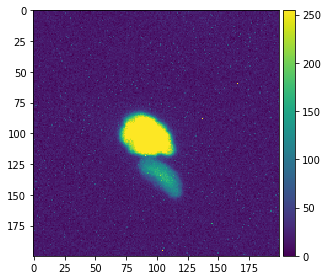

In [176]:
green = gfp_list[0]
red = rfp_list[0]
image_g = imread(os.path.join(glimpse_folder, 'gfp', green)).astype('uint16')
image_r = imread(os.path.join(glimpse_folder, 'rfp', red)).astype('uint16')
print(green)
print(type(image_g[100,100]))
imshow(image_r)#

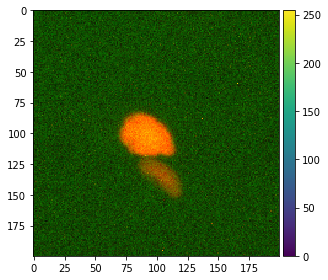

In [175]:

image_g = imread('gfp.tif').astype('uint16') # green image
image_r = imread('rfp.tif').astype('uint16') # red image
M, N = image_r.shape
rgb = np.zeros((M,N,3), dtype = 'uint16')   # empty rgb image of MxNx3 dimenesions
rgb[:,:,0] = image_r                        #add the red image to the MxNx0th (red) channel 
rgb[:,:,1] = image_g                        #add the green image to the MxNx1st (green) channel
imshow(rgb)
imsave('rgb.tif', rgb)